In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, GRU, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
train_data = pd.read_csv("train.csv", header=None, names=["class", "title", "description"])
test_data = pd.read_csv("test.csv", header=None, names=["class", "title", "description"])
classes = pd.read_csv("classes.txt", header=None).iloc[:, 0].tolist()

In [3]:
# Объединение заголовка и описания
train_data['text'] = train_data['title'] + " " + train_data['description']
test_data['text'] = test_data['title'] + " " + test_data['description']

X_train = train_data['text'].values
y_train = train_data['class'].values - 1
X_test = test_data['text'].values
y_test = test_data['class'].values - 1


In [4]:
# Токенизация и паддинг
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Разделение на обучающую и валидационную выборки
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_pad, y_train, test_size=0.2, random_state=42)

In [5]:
# Функция для создания моделей
def create_model(model_type):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim))
    if model_type == "1D-CNN":
        model.add(Conv1D(32, 5, activation='relu'))
        model.add(GlobalMaxPooling1D())
    elif model_type == "LSTM":
        model.add(LSTM(32, return_sequences=False))
    elif model_type == "GRU":
        model.add(GRU(32, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



In [6]:
# Общие параметры
embedding_dim = 64
num_classes = len(classes)
batch_size = 64
epochs = 10

# Словарь для хранения результатов
results = {}

# Обучение и тестирование моделей
for model_type in ["1D-CNN", "LSTM", "GRU"]:
    print(f"Training {model_type} model...")
    model = create_model(model_type)
    history = model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )
    # Оценка модели
    y_pred = np.argmax(model.predict(X_test_pad), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_type] = history
    print(f"{model_type} Test Accuracy: {accuracy:.4f}")


Training 1D-CNN model...
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6945 - loss: 0.7464 - val_accuracy: 0.9019 - val_loss: 0.3014
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8963 - loss: 0.3197 - val_accuracy: 0.9039 - val_loss: 0.2908
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9110 - loss: 0.2674 - val_accuracy: 0.9038 - val_loss: 0.2883
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9176 - loss: 0.2409 - val_accuracy: 0.9039 - val_loss: 0.2864
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9236 - loss: 0.2217 - val_accuracy: 0.9015 - val_loss: 0.2921
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9311 - loss: 0.2021 - val_accuracy: 0.8989 - val_loss: 0.2950
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9341 - loss: 0.1919 - val_accuracy: 0.9013 - val_loss: 0.2923
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy:

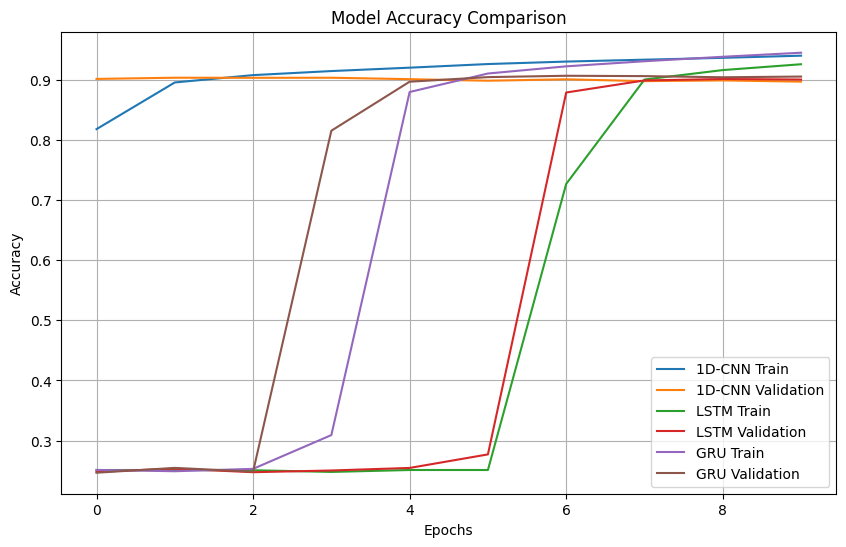

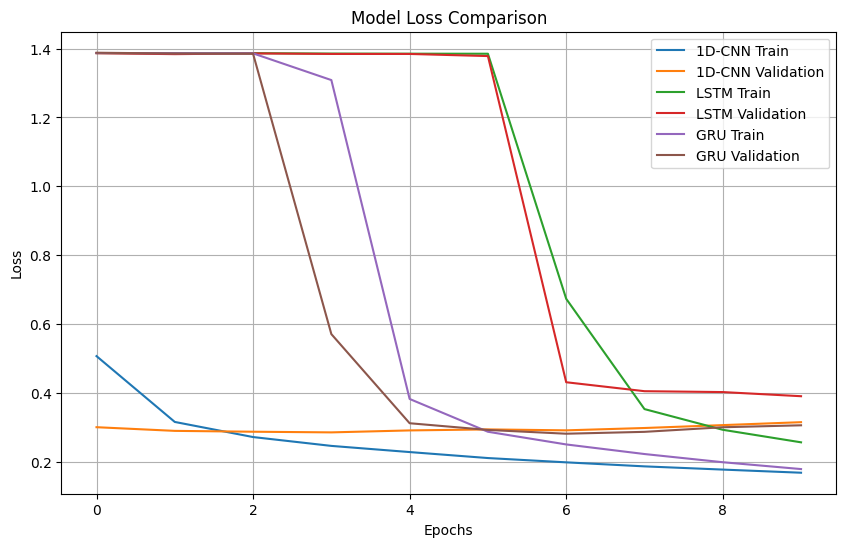

In [8]:
import matplotlib.pyplot as plt

# Функция для построения графиков
def plot_history(histories, metric, title):
    plt.figure(figsize=(10, 6))
    for model_type, history in histories.items():
        plt.plot(history.history[metric], label=f"{model_type} Train")
        plt.plot(history.history[f"val_{metric}"], label=f"{model_type} Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Построение графиков
plot_history(results, "accuracy", "Model Accuracy Comparison")
plot_history(results, "loss", "Model Loss Comparison")